- 의사결정나무

- 배깅(Bagging)

- 랜덤포리스트

- 부스팅: XGBoost, LightGBM

### 1. 준비: 타깃 라벨 인코딩 + 학습/평가 세팅

In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#  데이터프레임 생성 (고객 ID + 연체 여부)
# 고객 ID("customer") , 판매액("sales"), 소득액("income"), 금리( "interest"), 대출금("loans"), 연체여부("status")
df = pd.DataFrame({
    "customer":  [f"고객{i}" for i in range(1, 13)],
    "sales":     [100, 120, 130, 140, 150, 200, 220, 180, 190, 200, 210, 120],
    "income":    [10, 12, 13, 14, 15, 16, 17, 20, 22, 19, 20, 22],
    "interest":  [1.2, 1.5, 1.4, 1.3, 1.4, 1.5, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5],
    "loans": [100, 105, 102, 103, 104, 104, 105, 105, 103, 102, 104, 105],
    "status": [
        "정상", "정상", "연체", "정상", "정상", "정상",
        "정상", "정상", "정상", "정상", "연체", "연체"
    ]
})

df

,customer,sales,income,interest,loans,status
0,고객1,100,10,1.2,100,정상
1,고객2,120,12,1.5,105,정상
2,고객3,130,13,1.4,102,연체
3,고객4,140,14,1.3,103,정상
4,고객5,150,15,1.4,104,정상
5,고객6,200,16,1.5,104,정상
6,고객7,220,17,1.4,105,정상
7,고객8,180,20,1.4,105,정상
8,고객9,190,22,1.4,103,정상
9,고객10,200,19,1.5,102,정상


In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1) 타깃 라벨 인코딩 (정상/연체 -> 0/1)
le = LabelEncoder()
df["y"] = le.fit_transform(df["status"])   # 예: {'연체':0, '정상':1} 처럼 나올 수 있음
print("label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# 2) 특징(X), 타깃(y)
X = df[["sales", "income", "interest", "loans"]]   # customer, status는 제외
y = df["y"]

# 3) 교차검증(표본이 작으니 StratifiedKFold)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def cv_report(model, name):
    scores = cross_validate(
        model, X, y, cv=cv,
        scoring=["accuracy", "precision", "recall", "f1"],
        return_train_score=False
    )
    print(f"\n[{name}] CV mean scores")
    for k, v in scores.items():
        if k.startswith("test_"):
            print(f"  {k.replace('test_','')}: {np.mean(v):.3f}")


label mapping: {'연체': np.int64(0), '정상': np.int64(1)}


#### 1) 의사결정나무 (Decision Tree)

In [27]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=3)
cv_report(dt, "Decision Tree")



[Decision Tree] CV mean scores
  accuracy: 0.333
  precision: 0.556
  recall: 0.444
  f1: 0.489


#### 2) 배깅 (Bagging)

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    random_state=42
)
cv_report(bag, "Bagging")



[Bagging] CV mean scores
  accuracy: 0.333
  precision: 0.556
  recall: 0.444
  f1: 0.489


#### 3) 랜덤포리스트 (Random Forest)

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    max_depth=None
)
cv_report(rf, "Random Forest")



[Random Forest] CV mean scores
  accuracy: 0.417
  precision: 0.611
  recall: 0.556
  f1: 0.578


#### 4) 부스팅: XGBoost

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss"
)
cv_report(xgb, "XGBoost")



[XGBoost] CV mean scores
  accuracy: 0.750
  precision: 0.750
  recall: 1.000
  f1: 0.857


#### 5) 부스팅: LightGBM

In [7]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=15,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
cv_report(lgbm, "LightGBM")


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 6, number of negative: 2
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there 

### 2. 튜닝(하이퍼파라미터 최적화) 예시

#### A) 의사결정나무 GridSearchCV

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [1, 2, 3, 4, None],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3]
}

grid_dt = GridSearchCV(
    dt, param_grid_dt,
    cv=cv, scoring="f1",
    n_jobs=-1
)
grid_dt.fit(X, y)

print("Best params (DT):", grid_dt.best_params_)
print("Best CV f1 (DT):", grid_dt.best_score_)


Best params (DT): {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV f1 (DT): 0.6412698412698412


#### B) 랜덤포리스트 RandomizedSearchCV

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_dist_rf = {
    "n_estimators": [100, 300, 500, 800],
    "max_depth": [None, 2, 3, 4, 5],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt", "log2", None]
}

rand_rf = RandomizedSearchCV(
    rf, param_dist_rf,
    n_iter=30,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)
rand_rf.fit(X, y)

print("Best params (RF):", rand_rf.best_params_)
print("Best CV f1 (RF):", rand_rf.best_score_)


Best params (RF): {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 4}
Best CV f1 (RF): 0.8571428571428571


#### C) XGBoost 튜닝 (GridSearchCV 예시) 

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss"
)

param_grid_xgb = {
    "n_estimators": [100, 300, 600],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    xgb, param_grid_xgb,
    cv=cv, scoring="f1",
    n_jobs=-1
)
grid_xgb.fit(X, y)

print("Best params (XGB):", grid_xgb.best_params_)
print("Best CV f1 (XGB):", grid_xgb.best_score_)


Best params (XGB): {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Best CV f1 (XGB): 0.8571428571428571


#### D) LightGBM 튜닝 (RandomizedSearchCV 예시)

In [11]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

lgbm = LGBMClassifier(random_state=42)

param_dist_lgbm = {
    "n_estimators": [200, 500, 800, 1200],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [7, 15, 31, 63],
    "max_depth": [-1, 2, 3, 4, 5],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

rand_lgbm = RandomizedSearchCV(
    lgbm, param_dist_lgbm,
    n_iter=30,
    cv=cv,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)
rand_lgbm.fit(X, y)

print("Best params (LGBM):", rand_lgbm.best_params_)
print("Best CV f1 (LGBM):", rand_lgbm.best_score_)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 9, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there

### 3. 모델별 특성 중요도(feature importance) 비교

In [12]:
# 준비 (모델 재학습)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

feature_names = X.columns


In [13]:
# 한글 깨짐
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='Malgun Gothic')  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False

In [14]:
# 모델 학습

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
xgb = XGBClassifier(
    n_estimators=200, max_depth=3, learning_rate=0.05,
    random_state=42, eval_metric="logloss"
)
lgbm = LGBMClassifier(n_estimators=300, random_state=42)

models = {
    "Decision Tree": dt,
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgbm
}

for model in models.values():
    model.fit(X, y)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 9, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there

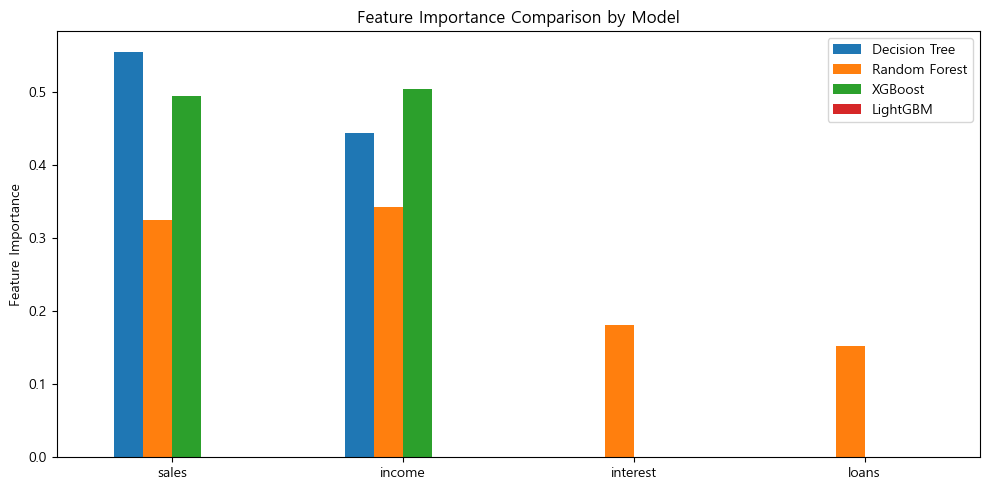

In [15]:
# 특성 중요도(feature importance) 비교
# (1) 모델별 중요도 추출

importance_df = pd.DataFrame(index=feature_names)

for name, model in models.items():
    importance_df[name] = model.feature_importances_

importance_df

# 정렬
importance_df.sort_values(by="Random Forest", ascending=False)

# 시각화 (모델별 비교) 
importance_df.plot(kind="bar", figsize=(10, 5))
plt.ylabel("Feature Importance")
plt.title("Feature Importance Comparison by Model")
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()


### 4. 혼동행렬(confusion matrix)

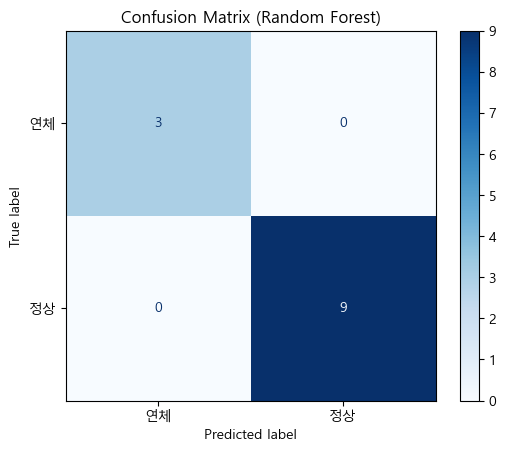

In [16]:
# 예측값 생성
y_pred = rf.predict(X)   # 예시: Random Forest 기준

# (2) 혼동행렬 계산
cm = confusion_matrix(y, y_pred)
cm

# (3) 혼동행렬 시각화 ⭐⭐⭐
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

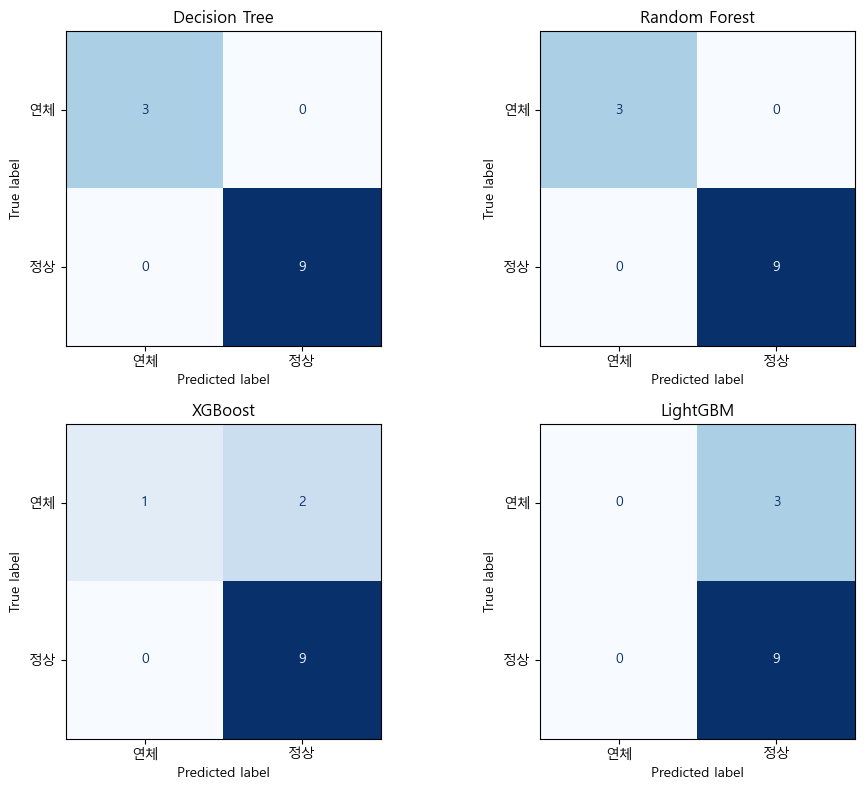

In [17]:
# 모델별 혼동행렬 한 번에 보기

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()



####  Train / Test 데이터 분리

- 1️⃣ Train / Test 데이터 분리
- 2️⃣ 모델 학습 (의사결정나무 · 랜덤포리스트 · XGBoost · LightGBM)
- 3️⃣ 특성 중요도 비교 (Train 기준)
- 4️⃣ 테스트 데이터로 혼동행렬 평가

#### 준비: X, y 정의 & 라벨 인코딩

In [18]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt

# 타깃 라벨 인코딩
le = LabelEncoder()
df["y"] = le.fit_transform(df["status"])  # 정상/연체 → 0/1

# 특징(X), 타깃(y)
X = df[["sales", "income", "interest", "loans"]]
y = df["y"]

feature_names = X.columns


#### Train / Test 데이터 분리

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,          # 테스트 30%
    stratify=y,             # 연체/정상 비율 유지
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)


Train size: (8, 4)
Test size : (4, 4)


#### 모델 학습 (Train 데이터만 사용)

In [20]:
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=3, learning_rate=0.05,
        random_state=42, eval_metric="logloss"
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300, learning_rate=0.05, random_state=42
    )
}

for model in models.values():
    model.fit(X_train, y_train)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 6, number of negative: 2
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there 

#### 특성 중요도 비교 (Train 기준)

In [21]:
importance_df = pd.DataFrame(index=feature_names)

for name, model in models.items():
    importance_df[name] = model.feature_importances_

importance_df


,Decision Tree,Random Forest,XGBoost,LightGBM
sales,0.000000,0.284024,0.0,0
income,0.000000,0.253450,0.0,0
interest,0.533333,0.201530,0.0,0
loans,0.466667,0.260996,0.0,0


##### 시각화

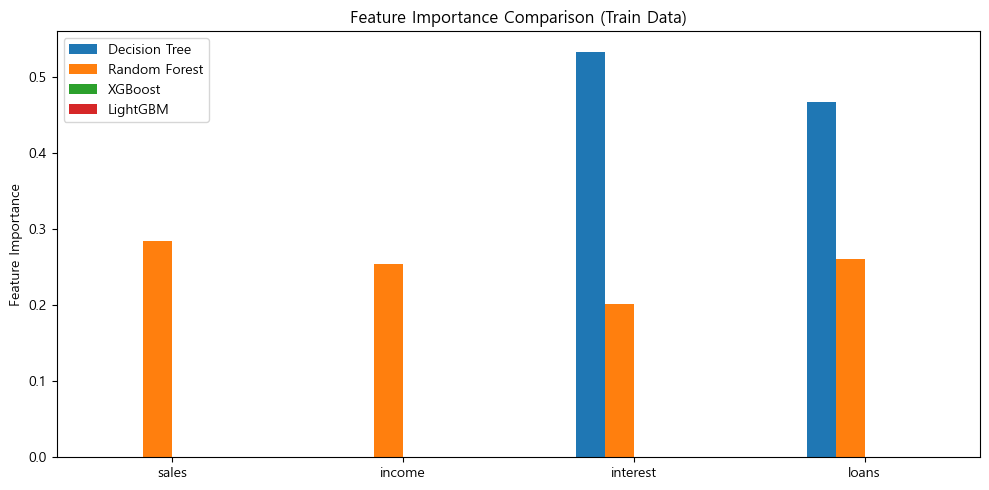

In [22]:
importance_df.plot(kind="bar", figsize=(10, 5))
plt.ylabel("Feature Importance")
plt.title("Feature Importance Comparison (Train Data)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### 혼동행렬 (Test 데이터 평가)

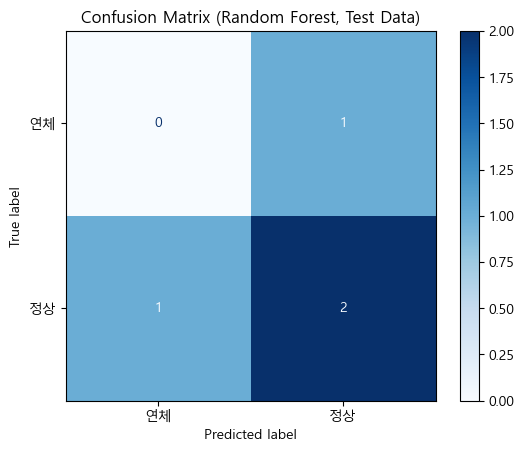

In [23]:
# 모델 하나 예시 (Random Forest)
rf = models["Random Forest"]

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Random Forest, Test Data)")
plt.show()



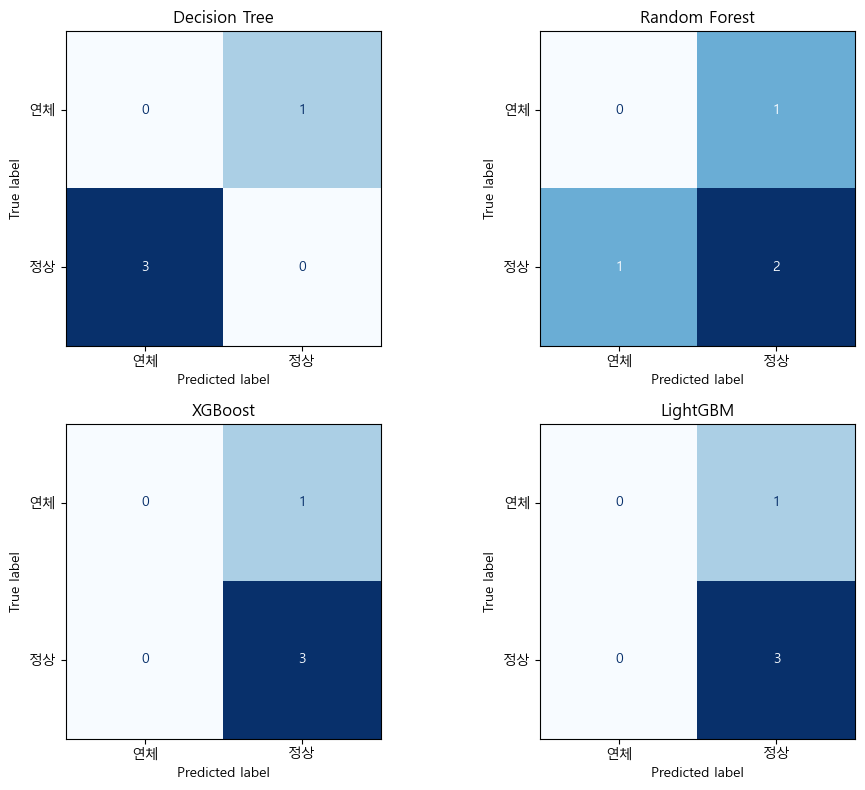

In [24]:
# 모든 모델 혼동행렬 한 번에 보기

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()
